# Data imports


In [74]:
import TNSPC as tp
import torch

device = torch.device('cpu')
#to use cude need to install the package independently
#device = torch.device('cuda')
torch.manual_seed(0)

### Importing mnist and saving to arff file

In [75]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

# Step 1: Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data[:10000]
X = X / 255.0
y = mnist.target[:10000].astype(int).to_numpy()

# Step 2: Convert to Pandas DataFrame
print("Converting dataset to DataFrame...")
df = pd.DataFrame(X, columns=[f'pixel{i}' for i in range(1, X.shape[1]+2)])
#df['class'] = y  # Append labels as the last column


# Step 3: Write to ARFF file manually
def write_arff(df, filename, relation_name, class_labels):
    with open(filename, 'w') as f:
        # Write relation name
        f.write(f"@relation {relation_name}\n\n")
        
        # Write attributes
        for column in df.columns[:-1]:
            f.write(f"@attribute {column} numeric\n")
        f.write(f"@attribute class_labels {{{','.join(map(str, class_labels))}}}\n\n")
        # Write data
        f.write("@data\n")
        for row in df.values:
            f.write(','.join(map(str, row)) + '\n')

output_file = 'mnist_2.arff'
write_arff(df, output_file, relation_name='mnist', class_labels=range(10))

print(f"ARFF file saved to {output_file}")


Loading MNIST dataset...
Converting dataset to DataFrame...
ARFF file saved to mnist_2.arff


### Loading in the data from the arff file

In [76]:
import TNSPC as tp
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from TNSPC.utils.utils import drawnow, arrange_figs
from TNSPC.layers.leaves import *
from TNSPC.layers.tn import *
from TNSPC.layers.spn import *
from TNSPC.layers.TNSPCclass import *
from TNSPC.utils.model import *


file_path = "mnist.arff"

df, attribute_mapping, leaves_types = tp.utils.data.hetdata(file_path, reorder=True)
print(df.values.shape)

frac_train = int(0.8*len(df))
frac_test = len(df) - int(0.8*len(df))
Xtrain = torch.tensor(df.values[:frac_train]).float()

print(Xtrain.shape)
Xtest = torch.tensor(df.values[frac_train:]).float()
print(y[:frac_train].shape)
Ytrain = torch.tensor(y[:frac_train]).int()
Ytest = torch.tensor(y[frac_train:]).int()

#%% Fit model
N = frac_train

(10000, 784)
torch.Size([8000, 784])
(8000,)


# PC model

### Model structure

In [77]:
from TNSPC.layers.leaves import NormalLeaf, CategoricalLeaf
from TNSPC.layers.TNSPCclass import MultiLeaf

# Hyperparameters
T = 1 # Number of tracks
C = 10  # Number of channels
V = 784  # Number of input variables (e.g., pixels)
classes = 10  # Number of output classes (e.g., digits 0-9)

# Define individual leaf distributions
input_leaf = BernoulliLeaf(T, V, C)         # Gaussian for pixel inputs
output_leaf = CategoricalLeaf(T, 1, C, 10)  # Categorical for class labels


# Combine them into a MultiLeaf
multi_leaf = MultiLeaf(input_leaf, output_leaf)

print(multi_leaf[1])

pc_model = Sequential(multi_leaf,
                     Weightsum(T, V + 1, C)) 


print(pc_model)

CategoricalLeaf()
Sequential(
  (0): MultiLeaf(
    (0): BernoulliLeaf()
    (1): CategoricalLeaf()
  )
  (1): Weightsum()
)


In [78]:
Xtrain = Xtrain > 0

In [79]:
concatenated = torch.cat((Xtrain.float(), Ytrain[:,None]), dim =1)
concatenated.shape
concatenated[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 

In [80]:
x = concatenated
for i, layer in enumerate(pc_model):
    x = layer(x)
    print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}")

print()

After layer 0 (MultiLeaf): torch.Size([8000, 1, 785, 10])
After layer 1 (Weightsum): torch.Size([8000])



In [81]:
pc_model.train()
tp.utils.model.train(pc_model, [concatenated], device = device, epochs = 10, show_progress=True)

Epoch 10, Avg P: -182.4648: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


In [82]:
Xtest = Xtest > 0
empty_y = torch.zeros(Xtest.shape[0])
empty_y[:] = float('nan')
concatenated_test = torch.cat((Xtest.float(), empty_y[:,None]), dim =1)


In [83]:
leaves_types = ["N"] * 784 + ["C"]
print(leaves_types)

imp_func = lambda model, batch, device: tp.utils.impute.impute(model, batch, leaves_types, device = device)

#We can now impute the data introducing some randomn missing values

p = 0.5
mXtest = torch.clone(concatenated_test)

b_mXtest = tp.utils.data.batch(mXtest, 200)

Ximputed = tp.utils.impute.b_impute(pc_model, b_mXtest , imp_func, device)

predicted_label = Ximputed[:,-1]


['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [84]:
num_correct = torch.sum(predicted_label == Ytest)
print(num_correct/frac_test)

tensor(0.5955)


# CNN model

### Create Torch dataset

In [85]:

# Create Dataset objects for training and validation
train_dataset = torch.utils.data.TensorDataset(Xtrain.view(-1, 1, 28, 28), Ytrain)
val_dataset = torch.utils.data.TensorDataset(Xtest.view(-1, 1, 28, 28), Ytest)

# Create DataLoader objects for loading data in batches
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Define network structure

#### CNN Model with 2 FF layers 

In [86]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes = 10):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.print_size = PrintSize()

    def forward(self, x):

      x = self.dropout(self.pool(F.relu(self.conv1(x.float()))))
      x = self.dropout(self.pool(F.relu(self.conv2(x))))

      x = self.print_size(x)

      x = x.view(x.size(0), -1)
      x = self.dropout(F.relu(self.fc1(x)))

      x = self.fc2(x)

      return x
    
    def return_hidden(self, x):
      x = self.dropout(self.pool(F.relu(self.conv1(x.float()))))
      x = self.dropout(self.pool(F.relu(self.conv2(x))))

      x = self.print_size(x)

      x = x.view(x.size(0), -1)
        
      return x

cnn_model_2l = Model(10)
device = torch.device('cpu')  # use cuda or cpu
cnn_model_2l.to(device)
print(cnn_model_2l)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (print_size): PrintSize()
)


#### CNN Model with 1 FF layer 

In [87]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes = 10):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 7 * 7, num_classes)

        self.print_size = PrintSize()

    def forward(self, x):

      x = self.dropout(self.pool(F.relu(self.conv1(x.float()))))
      x = self.dropout(self.pool(F.relu(self.conv2(x))))

      x = self.print_size(x)

      x = x.view(x.size(0), -1)
      x = self.fc1(x)

      return x
    
    def return_hidden(self, x):
      x = self.dropout(self.pool(F.relu(self.conv1(x.float()))))
      x = self.dropout(self.pool(F.relu(self.conv2(x))))

      x = self.print_size(x)

      x = x.view(x.size(0), -1)
        
      return x

cnn_model = Model(10)
device = torch.device('cpu')  # use cuda or cpu
cnn_model.to(device)
print(cnn_model)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=10, bias=True)
  (print_size): PrintSize()
)


### Training CNN

In [88]:
# Initialize the network, loss function, and optimizer
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_2l.parameters(), lr=0.001)

# Train the model
epochs = 10
for epoch in range(epochs):
    cnn_model_2l.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
            # Convert labels to Long type
        labels = labels.long()
        
        # Forward pass
        outputs = cnn_model_2l(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation step
    cnn_model_2l.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels.long()

            outputs = cnn_model_2l(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%")


Size: torch.Size([64, 64, 7, 7])
Epoch 1/10, Training Loss: 0.7857, Validation Loss: 0.3289, Validation Accuracy: 89.70%
Epoch 2/10, Training Loss: 0.2650, Validation Loss: 0.2400, Validation Accuracy: 92.45%
Epoch 3/10, Training Loss: 0.1833, Validation Loss: 0.1645, Validation Accuracy: 94.65%
Epoch 4/10, Training Loss: 0.1487, Validation Loss: 0.1490, Validation Accuracy: 95.25%
Epoch 5/10, Training Loss: 0.1231, Validation Loss: 0.1443, Validation Accuracy: 95.20%
Epoch 6/10, Training Loss: 0.1022, Validation Loss: 0.1208, Validation Accuracy: 95.95%
Epoch 7/10, Training Loss: 0.0953, Validation Loss: 0.1312, Validation Accuracy: 95.90%
Epoch 8/10, Training Loss: 0.0799, Validation Loss: 0.1055, Validation Accuracy: 96.45%
Epoch 9/10, Training Loss: 0.0714, Validation Loss: 0.1099, Validation Accuracy: 96.60%
Epoch 10/10, Training Loss: 0.0635, Validation Loss: 0.1025, Validation Accuracy: 96.45%


# CNN + PC

In [89]:
final_conv_out = cnn_model_2l.return_hidden(Xtrain.view(-1, 1, 28, 28))

In [90]:
final_conv_out.shape

torch.Size([8000, 3136])

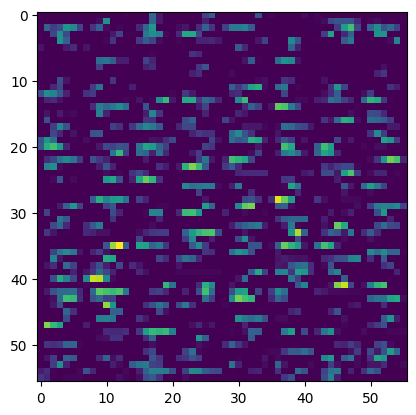

In [91]:
final_conv_out[0]
from matplotlib import pyplot as plt

plt.imshow(final_conv_out[0].detach().numpy().reshape(56, 56))

In [92]:
Xtrain_mixed = final_conv_out
Xtrain_mixed = Xtrain_mixed > 0

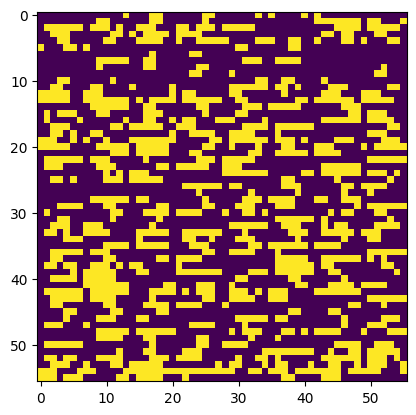

In [93]:
plt.imshow(Xtrain_mixed[0].detach().numpy().reshape(56, 56))
#plt.xticks(torch.linspace(0, 54, 7))

In [94]:
from TNSPC.layers.leaves import NormalLeaf, CategoricalLeaf
from TNSPC.layers.TNSPCclass import MultiLeaf

# Hyperparameters
T = 1 # Number of tracks
C = 10  # Number of channels
V = 3136  # Number of input variables (e.g., pixels)
classes = 10  # Number of output classes (e.g., digits 0-9)

# Define individual leaf distributions
input_leaf = BernoulliLeaf(T, V, C)         # Gaussian for pixel inputs
output_leaf = CategoricalLeaf(T, 1, C, 10)  # Categorical for class labels


# Combine them into a MultiLeaf
multi_leaf = MultiLeaf(input_leaf, output_leaf)

print(multi_leaf[1])

mixed_model = Sequential(multi_leaf,
                     Weightsum(T, V + 1, C)) 

#model = tp.utils.model.CP_(T, V, C, multi_leaf).to(device)

print(mixed_model)

CategoricalLeaf()
Sequential(
  (0): MultiLeaf(
    (0): BernoulliLeaf()
    (1): CategoricalLeaf()
  )
  (1): Weightsum()
)


In [95]:
concatenated = torch.cat((Xtrain_mixed.float(), Ytrain.int()[:,None]), dim =1)
concatenated.shape
concatenated[0]

tensor([0., 0., 0.,  ..., 0., 0., 5.])

In [96]:
x = concatenated
for i, layer in enumerate(mixed_model):
    x = layer(x)
    print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}")

print()

After layer 0 (MultiLeaf): torch.Size([8000, 1, 3137, 10])
After layer 1 (Weightsum): torch.Size([8000])



In [97]:
mixed_model.train()
tp.utils.model.train(mixed_model, [concatenated], device = device, epochs = 10, show_progress=True)

Epoch 10, Avg P: -1007.3081: 100%|██████████| 10/10 [00:37<00:00,  3.74s/it]


In [101]:
Xtest_mixed = cnn_model_2l.return_hidden(Xtest.view(-1, 1, 28, 28))
Xtest_mixed = Xtest_mixed > 0
empty_y = torch.zeros(Xtest_mixed.shape[0])
empty_y[:] = float('nan')
concatenated_test = torch.cat((Xtest_mixed.float(), empty_y[:,None]), dim =1)

In [102]:
leaves_types = ["N"] * 3136 + ["C"]
print(leaves_types)

imp_func = lambda model, batch, device: tp.utils.impute.impute(model, batch, leaves_types, device = device)

#We can now impute the data introducing some randomn missing values

p = 0.5
mXtest = torch.clone(concatenated_test)

b_mXtest = tp.utils.data.batch(mXtest, 200)

Ximputed = tp.utils.impute.b_impute(mixed_model, b_mXtest , imp_func, device)

predicted_label = Ximputed[:,-1]


['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [103]:
num_correct = torch.sum(predicted_label == Ytest)
print(num_correct/frac_test)

tensor(0.6610)
